In [32]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("../data/data.csv")

<Axes: ylabel='Frequency'>

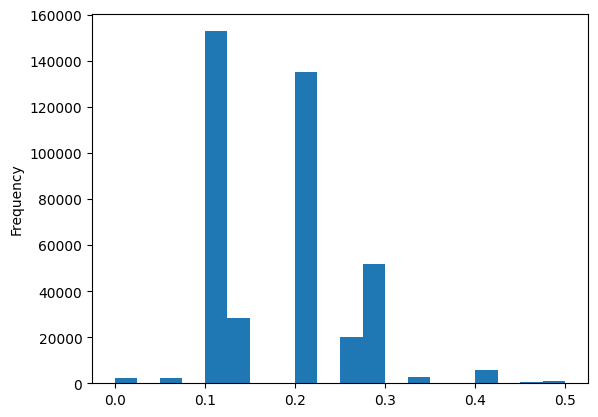

In [3]:
data['FREQU_COUPLE'].plot.hist(bins=20)

In [25]:
target = "AMPL_COUPLE"
X = data.drop(columns=[target])
y = data[target]
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
preprocessing_pipeline = Pipeline(steps=[
    ("scaling", ColumnTransformer([
        ("num", num_transformer, [col for col in X.columns])
    ]))
])
model_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessing_pipeline),
    ("regressor", XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
y_train_pred = model_pipeline.predict(X_train)

In [26]:
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", mean_squared_error(y_train, y_train_pred, squared=False))
print("R2:", r2_score(y_train, y_train_pred))

MAE: 18.90913004512743
RMSE: 28.92154472147951
R2: 0.8690160893858934


In [27]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

MAE: 20.130912217001235
RMSE: 36.82697374666276
R2: 0.7848472738318873


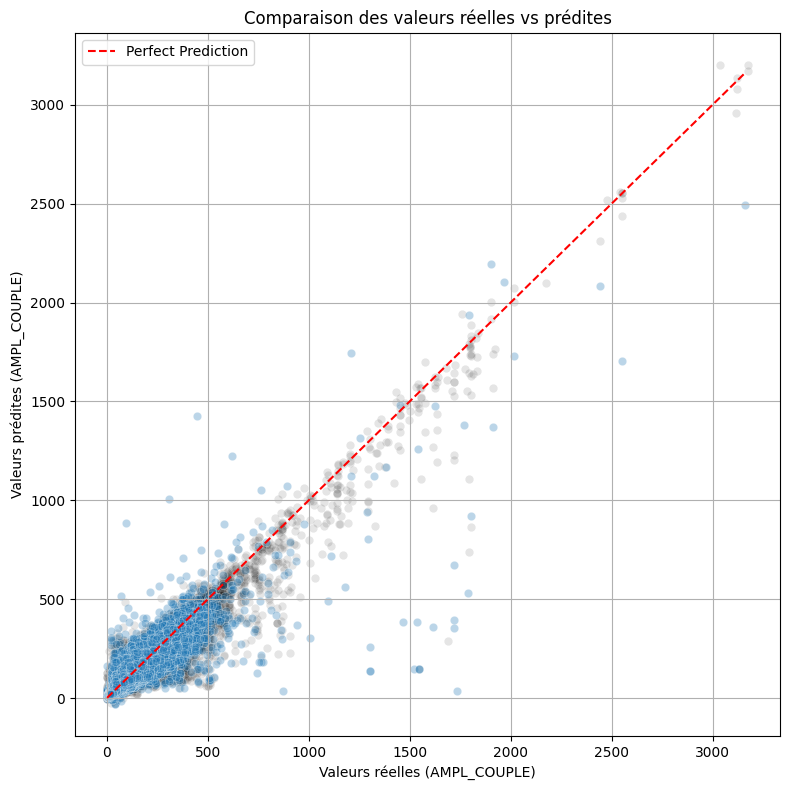

In [28]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.1, c='k')
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Valeurs réelles (AMPL_COUPLE)")
plt.ylabel("Valeurs prédites (AMPL_COUPLE)")
plt.title("Comparaison des valeurs réelles vs prédites")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Hyper Params Optimization

In [33]:
N_ITER = 10

In [ ]:
%%time
xgb_param_dist = {
    "regressor__n_estimators": randint(100, 300),
    "regressor__max_depth": randint(3, 15),
    "regressor__learning_rate": uniform(0.01, 0.3),
    "regressor__subsample": uniform(0.6, 0.4),
    "regressor__colsample_bytree": uniform(0.6, 0.4),
    "regressor__gamma": uniform(0, 5),
    "regressor__reg_alpha": uniform(0, 1),
    "regressor__reg_lambda": uniform(0, 1)
}

xgb_random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=N_ITER,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

xgb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
y_pred = xgb_random_search.predict(X_test)
y_train_pred = xgb_random_search.predict(X_train)

In [ ]:
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", mean_squared_error(y_train, y_train_pred, squared=False))
print("R2:", r2_score(y_train, y_train_pred))

In [ ]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

In [ ]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.1, c='k')
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Valeurs réelles (AMPL_COUPLE)")
plt.ylabel("Valeurs prédites (AMPL_COUPLE)")
plt.title("Comparaison des valeurs réelles vs prédites")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()